# **Facial Expression Recognition** via Logistic Regression and K-Nearest Neighbors

## 1. Import Libraries 📥


In [1]:
import pandas as pd
import numpy as np
import cv2
from sklearn.utils import shuffle
from skimage.feature import hog
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression


## 2. Load the Dataset 📂 


In [2]:
# Define path to the CSV file
csv_path = "/kaggle/input/fer2013/fer2013.csv"  

# Read the CSV file
df = pd.read_csv(csv_path, on_bad_lines='skip', engine='python')

df.head()

df.shape

(35887, 3)

In [3]:
df["emotion"].unique()

array([0, 2, 4, 6, 3, 5, 1])

In [4]:
df.isnull().sum()

emotion    0
pixels     0
Usage      0
dtype: int64

##  3. Data Preprocessing & Image Display 🧑‍💻


###  Emotion Dictionary 😁

In [5]:
# Emotion mapping
emotion_dict = { 0:'Angry', 1:'Disgust',2:'Fear', 3:'Happy', 4:'Sad', 5:'Surprise', 6:'Neutral'}

###  Plot Sample Images 📊

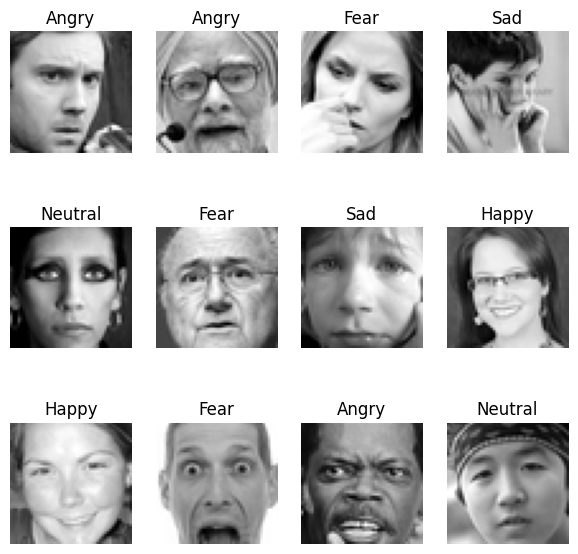

In [6]:
px = 1 / plt.rcParams['figure.dpi']
fig = plt.figure(figsize=(720 * px, 720 * px)) 
rows = 3
columns = 4

subset_df = df.reset_index(drop=True)  

for i in range(rows * columns):
    fig.add_subplot(rows, columns, i + 1)
    
    # Extract pixel values from current row
    pixels = np.fromstring(subset_df['pixels'].iloc[i], sep=' ')  
    image = pixels.reshape(48, 48) 
    
    plt.imshow(image, cmap='gray')
    plt.axis('off') 
    plt.title(emotion_dict.get(subset_df['emotion'].iloc[i], 'Unknown')) 


### Feature Extraction 🤖


In [7]:
# Extract pixel values and labels
pixels = df['pixels']
labels = df['emotion']

# Initialize lists for processed data and labels
data = []
processed_labels = []

# Define image size for resizing
image_size = (64, 64)

# Dictionary to count images per label
emotion_count = {label: 0 for label in np.unique(labels)}

# Maximum images per emotion
max_images_per_emotion = 5000

# HOG Feature Extraction Function
def extract_hog_features(image):
    features = hog(image,
                   pixels_per_cell=(8, 8),
                   cells_per_block=(2, 2),
                   orientations=9,
                   visualize=False)
    return features


###  Process Images 🖼️


In [8]:
# Re-initialize the dataframe
df = df.reset_index(drop=True)  

# Count images per emotion
emotion_count = {emotion: 0 for emotion in df["emotion"].unique()}  

# Process each image
for i in range(len(df)):
    try:
        label = df['emotion'].iloc[i]
        if emotion_count[label] >= max_images_per_emotion:
            continue

        # Convert pixels to array
        pixel_values = np.array([int(p) for p in df['pixels'].iloc[i].split()], dtype=np.uint8)
        img = pixel_values.reshape(48, 48)

        # Resize image
        img_resized = cv2.resize(img, image_size)

        # Extract HOG features
        hog_features = extract_hog_features(img_resized)

        # Store features and labels
        data.append(hog_features)
        processed_labels.append(label)

        # Update image count
        emotion_count[label] += 1

    except Exception as e:
        print(f"Error processing row {i}: {e}")

    # Stop when all classes reach the max number of images
    if all(count >= max_images_per_emotion for count in emotion_count.values()):
        break


## 4. Train-Test Split 🎲


In [9]:
# Convert to numpy arrays
data = np.array(data)
processed_labels = np.array(processed_labels)

# Shuffle dataset
data, processed_labels = shuffle(data, processed_labels, random_state=42)

print(f"Processed {len(data)} images.")

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(data, processed_labels, test_size=0.2, random_state=42)

print(f"Training set: {len(X_train)}, Test set: {len(X_test)}")


Processed 29502 images.
Training set: 23601, Test set: 5901


## 5. Logistic Regression Model 📈


In [10]:
# Initialize and train the Logistic Regression model
logistic = LogisticRegression(penalty='l2', solver='sag', C=1.0, max_iter=1000)
History = logistic.fit(X_train, y_train)

# Predictions
y_train_pred_log = logistic.predict(X_train)
y_test_pred_log = logistic.predict(X_test)

print(f"logistic - Train accuracy: {accuracy_score(y_train, y_train_pred_log)}")
print(f"logistic - Test accuracy: {accuracy_score(y_test, y_test_pred_log)}")


logistic - Train accuracy: 0.5433668064912504
logistic - Test accuracy: 0.41365870191492965


### 🎯 Confusion Matrix for logistic 

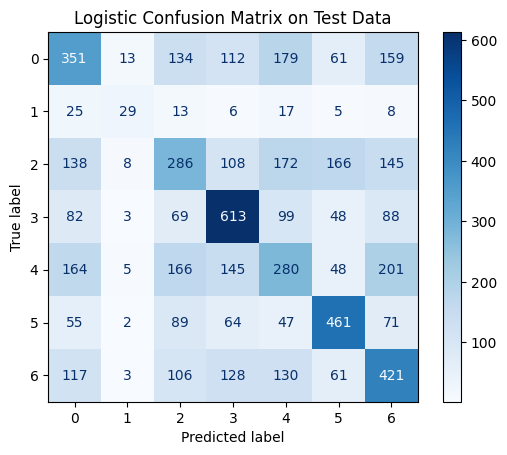

In [11]:
# Confusion Matrix
classes = np.unique(processed_labels)

# Plot Confusion Matrix for logistic
cm_log = confusion_matrix(y_test, y_test_pred_log)
disp_log = ConfusionMatrixDisplay(confusion_matrix=cm_log, display_labels=classes)
disp_log.plot(cmap=plt.cm.Blues)
plt.title("Logistic Confusion Matrix on Test Data")
plt.show()


In [12]:
# Classification Report and Accuracy
print(classification_report(y_train, y_train_pred_log))
print(classification_report(y_test, y_test_pred_log))

              precision    recall  f1-score   support

           0       0.50      0.50      0.50      3944
           1       0.77      0.47      0.59       444
           2       0.48      0.41      0.44      3977
           3       0.61      0.69      0.65      3998
           4       0.46      0.45      0.46      3991
           5       0.67      0.70      0.68      3213
           6       0.53      0.55      0.54      4034

    accuracy                           0.54     23601
   macro avg       0.57      0.54      0.55     23601
weighted avg       0.54      0.54      0.54     23601

              precision    recall  f1-score   support

           0       0.38      0.35      0.36      1009
           1       0.46      0.28      0.35       103
           2       0.33      0.28      0.30      1023
           3       0.52      0.61      0.56      1002
           4       0.30      0.28      0.29      1009
           5       0.54      0.58      0.56       789
           6       0.39 

### ROC Curve for Logistic Regression 🚀


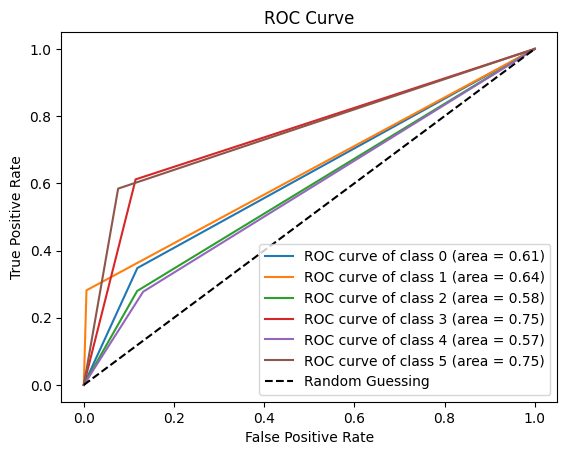

In [13]:
# Compute ROC curve and AUC for Logistic Regression
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(6):  # Adjust number of classes
    fpr[i], tpr[i], _ = roc_curve(y_test == i, y_test_pred_log == i)
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve
plt.figure()

for i in range(6):  # Adjust number of classes
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', label='Random Guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()


## 6. K-Nearest Neighbors Model (KNN) 🔍 


### Classification 

In [14]:
# Initialize and train the KNN model
knn = KNeighborsClassifier(n_neighbors=15, algorithm="brute")
knn.fit(X_train, y_train)

# Predictions
y_train_pred_knn = knn.predict(X_train)
y_test_pred_knn = knn.predict(X_test)

# Classification Report and Accuracy
print(f"KNN - Train accuracy: {accuracy_score(y_train, y_train_pred_knn)}")
print(f"KNN - Test accuracy: {accuracy_score(y_test, y_test_pred_knn)}")


KNN - Train accuracy: 0.5357400110164824
KNN - Test accuracy: 0.4333163870530419


### 🎯 Confusion Matrix for KNN

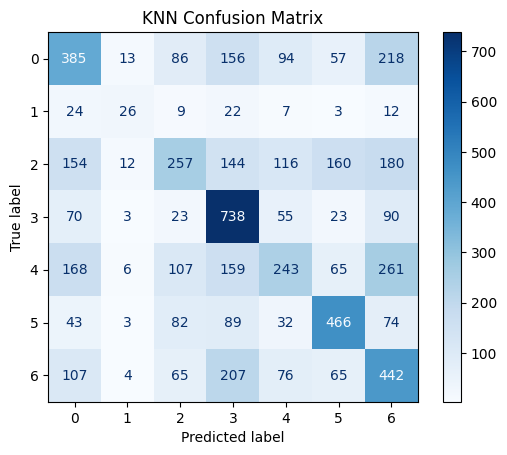

In [15]:
# Confusion Matrix for KNN
cm_knn = confusion_matrix(y_test, y_test_pred_knn)
disp_knn = ConfusionMatrixDisplay(confusion_matrix=cm_knn, display_labels=np.unique(processed_labels))
disp_knn.plot(cmap=plt.cm.Blues)
plt.title("KNN Confusion Matrix")
plt.show()

In [16]:
# Classification Report
print(classification_report(y_train, y_train_pred_knn))
print(classification_report(y_test, y_test_pred_knn))

              precision    recall  f1-score   support

           0       0.50      0.50      0.50      3944
           1       0.49      0.33      0.40       444
           2       0.54      0.37      0.44      3977
           3       0.54      0.79      0.64      3998
           4       0.56      0.36      0.44      3991
           5       0.64      0.67      0.65      3213
           6       0.48      0.57      0.52      4034

    accuracy                           0.54     23601
   macro avg       0.53      0.51      0.51     23601
weighted avg       0.54      0.54      0.53     23601

              precision    recall  f1-score   support

           0       0.40      0.38      0.39      1009
           1       0.39      0.25      0.31       103
           2       0.41      0.25      0.31      1023
           3       0.49      0.74      0.59      1002
           4       0.39      0.24      0.30      1009
           5       0.56      0.59      0.57       789
           6       0.35 

### 🚨 ROC Curve for KNN

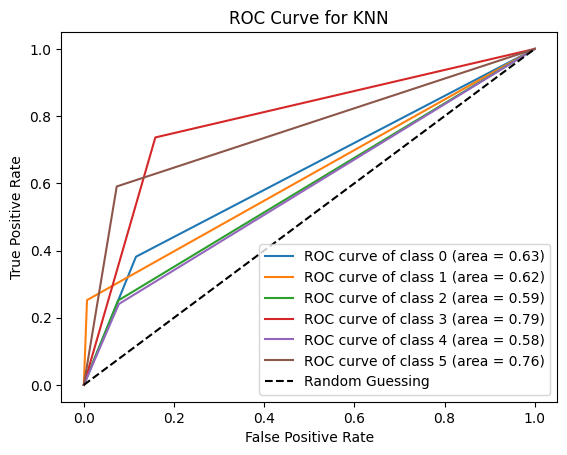

In [17]:
# Compute ROC curve and AUC for KNN
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(6):  # Adjust number of classes
    fpr[i], tpr[i], _ = roc_curve(y_test == i, y_test_pred_knn == i)
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for KNN
plt.figure()

for i in range(6):  # Adjust number of classes
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', label='Random Guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for KNN')
plt.legend(loc="lower right")
plt.show()
